# Circularity Measures

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
import pickle
import torch
import jax
import jax.numpy as jnp
import haiku as hk
from torch.utils.data import Dataset, DataLoader
sns.set_theme()
%matplotlib inline

In [2]:
# Enable double precision data with JAX
# this only works on startup!
from jax.config import config
config.update("jax_enable_x64", True)

In [7]:
from complex_nn.layers import Cmplx_Linear, Dropout
from complex_nn.activations import cardioid
from complex_nn.optimizers import cmplx_adam
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.utils import small_training_summary

### Circularity in complex analysis

An important characteristic of a complex random variable is the so-called `circularity` property, or
lack of it.

Circular random variables have, in fact, vanishing pseudo-variance, index that its real and imaginary parts are statistically uncorrelated. Under this perspective, a [recent work](https://arxiv.org/abs/2009.08340v2) have shown
that the circularity property of a dataset can significantly impact on the different performances, obtained using a complex-valued model with respect to its real counterpart. At least in principle, in fact, complex-valued networks seems to benefit more of dataset presenting inherent correlations. <br>
Let us denote the vector $u=[X,Y]^T$ as the real vector built by stacking the real and imaginary parts of a complex random variable $Z = X + iY$. The probability density function of $Z$ can be identified with the pdf of $u$. The variance of $Z$ is defined by:

$$
\sigma^2_Z = E[|Z - E[Z]|^2] = E[|Z|^2] - |E[Z]|^2 = \sigma_X^2 + \sigma_Y^2
$$

where $\sigma^2_X$ and $\sigma^2_Y$ are respectively the variance of $X$ and $Y$.

However, this parameters does not bring any information about the `covariance` of $Z$:

$$
\sigma_{XY} \triangleq E[\left(X-E[X]\right)\left(Y-E[Y]\right)]
$$

for which we need to rely on another statistical quantity defined for complex random variables, i.e. the `pseudo-variance`:

$$
\tau_Z\triangleq E[\left(Z-E[Z]\right)^2] = \sigma^2_{X} - \sigma^2_Y + 2i\sigma_{XY}
$$

Unlike the variance of $Z$, which is always real and positive, the pseudo-variance is in general complex. <br>
We define the `circular quotient` $\rho_Z$ as:

$$
\rho_Z = \frac{\tau_Z}{\sigma^2_Z}
$$

Additionally, we can define also a `correlation coefficient` among real and imaginary parts of $Z$:

$$
\rho = \frac{\sigma_{XY}}{\sigma_X\sigma_Y} 
$$

In some papers, the circular quotient is defined as a covariance measure between $Z$ and $\bar{Z}$, so among a random variable and its complex conjugate, rather than considering real and imaginary parts. We believe that those formulations in the end are equivalent from a practical point of view and so they can be used interchangeably. <br>
Another interesting fact is that $\rho_Z$ possess an intuitive geometrical interpretation since the modulus and phase of its principal square-root are equal to the eccentricity and angle of orientation of the ellipse defined by the covariance matrix of the real and imaginary parts of $Z$.

### Classification of circular features

The idea behind this analysis is to understand how much complex-valued models can effectively benefit of data with good circularity properties. For this reason we will generate two distinct complex datasets, one with high correlations among real and imaginary components, and one with poor correlations.

An easy way to generate data with determined circularity is to rely on the `complex normal distribution`, that characterizes complex random variables whose real and imaginary parts are jointly normal. Differently from its real-valued counterpart, such distribution depends on three parameters:
* the _location_ $\mu$;
* the _covariance matrix_ $\Gamma$;
* the _location matrix_ $C$.

The `standard complex normal` is the univariate distribution with $\mu=0$, $\Gamma=1$ and $C=0$.

A complex random vector $Z$ is called circularly symmetric if for every $\varphi\in[-\pi,\pi)$ the distribution of $e^{i\varphi}Z$ is the same of the distribution of $Z$. The PDF then satisfies $f(z)=cg(|z|^2)$ for some non-negative function $g$ and normalizing constant $c$. Hence, the regions of constant contours are circles in the complex plane. Central normal complex random vectors that are circularly symmetric are of particular interest because they are fully specified by the covariance matrix $\Gamma$.

We can generate circular random complex data simply exploiting the `multivariate_random_normal` distribution, supported by numpy. We just need to generate 2-dimensional data, for the real and imaginary part respectively. Tuning the corresponding covariance matrix we can then regulate the two main sources of circularity:
* $\sigma_x \neq \sigma_y$
* $\sigma_{xy} \neq 0$

If a random variable $z=x+iy$ has zero-mean, it is circular complex normal if $\sim N_2(0,\sigma^2)$, i.e. $x$ and $y$ are iid real variables with variance $\sigma^2$. Thus, $\sigma_z^2=2\sigma^2$ and the pdf becomes:
$$
f(x,y|\sigma^2) = f(z|\sigma_z^2) = \frac{1}{\pi\sigma^2}exp({-|z|^2 /\sigma_z^2})
$$

In [3]:
def generate_cmplx_distribution(cov_mat, shape):
    """Generate an array of complex-valued random numbers distributed according to a zero-centered
    multivariate normal distribution, given in input the corresponding covariance matrix."""    
    return np.random.multivariate_normal(np.zeros(2), cov_mat, size=shape).view(np.complex128).squeeze()

Before going on, let's define a function that compute the empirical circularity and correlations coefficients. First it quantify how much our data are effectively correlated; second, it acts as a control instruction to check the correctnees of the sample generated.

In [5]:
def get_circularity_coeff(dataset, verbose=False):
    
    cov_mat = 0.
    
    # Compute the covariance matrix among real and imaginary parts
    # of the whole dataset
    
    for i in tqdm(range(len(dataset)), leave=False):
        cov_mat += np.cov(dataset[i][0].real.flatten(), dataset[i][0].imag.flatten()) 
        
    # The covariance matrix will have the following structure:  [[Sx**2, Sxy], [Sxy, Sy**2]]
    cov_mat = cov_mat / len(dataset)

    # Compute the variance of Z:   Sz**2 = E[ |Z - E[Z]|**2 ] = Sx**2 + Sy**2
    Sx2 = cov_mat[0,0]
    Sy2 = cov_mat[1,1]
    Sz2 = cov_mat.trace() 
    
    # Get the covariance:   Sxy = E[(X-E[X])(Y-E[Y])]
    Sxy = cov_mat[0,1]
    
    # Compute the pseudo-variance:   Tz = E[ (Z-E[Z])**2 ] = Sx**2 - Sy**2 + 2iSxy
    Tz = Sx2 - Sy2 + 2.j*Sxy
    
    # Compute the circularity quotient:  rhoZ = Tz / Sz**2
    rhoZ = Tz / Sz2
    
    # Compute the correlation coefficient:  rho = Sxy / SxSy
    rho = Sxy / (np.sqrt(Sx2)*np.sqrt(Sy2))
    
    if verbose:
        return cov_mat, Sz2, Tz, rhoZ, rho
    else:
        return rhoZ, rho

Define also a Pytorch Dataset object to store such data and allow the training.

In [6]:
class NpyDataset(Dataset):
    
    def __init__(self, data, label):
        
        self.x = data
        self.y = np.full(len(data), label)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx].flatten())
        one_hot_y = torch.tensor(np.eye(2)[self.y[idx]])
        
        return (x, one_hot_y)

Let's start generating two simple __circular__ distributions. <br>
Conditions: $\sigma_x = \sigma_y$ and $\sigma_{xy}=0$.

In [6]:
circ1 = NpyDataset(generate_cmplx_distribution(cov_mat=np.array([[1.0, 0.],[0., 1.0]]), shape=(5000,128)), label=0)
circ1_rhoz, circ1_rho = get_circularity_coeff(circ1)
print('Circularity coefficient: {:.4f}'.format(circ1_rhoz))
print('Correlation coefficient: {:.4f}'.format(circ1_rho))

circ2 = NpyDataset(generate_cmplx_distribution(cov_mat=np.array([[3.0, 0.],[0., 3.0]]), shape=(5000,128)), label=1)
circ2_rhoz, circ2_rho = get_circularity_coeff(circ2)
print('Circularity coefficient: {:.4f}'.format(circ2_rhoz))
print('Correlation coefficient: {:.4f}'.format(circ2_rho))

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.0003-0.0003j
Correlation coefficient: -0.0003


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.0009+0.0011j
Correlation coefficient: 0.0011


Plot an example of such samples.

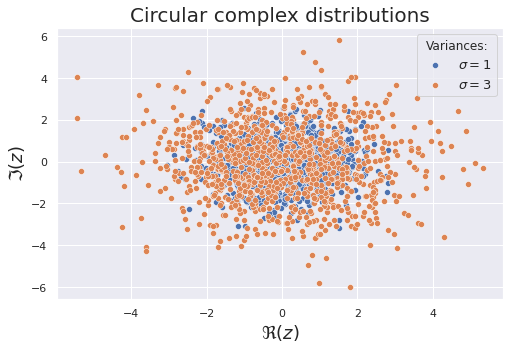

In [7]:
sample1 = generate_cmplx_distribution(cov_mat=np.array([[1.0, 0.],[0., 1.0]]), shape=(1000,))
sample2 = generate_cmplx_distribution(cov_mat=np.array([[3.0, 0.],[0., 3.0]]), shape=(1000,))

fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.scatterplot(x=sample1.real, y=sample1.imag, ax=ax, label=r'$\sigma = 1.$')
sns.scatterplot(x=sample2.real, y=sample2.imag, ax=ax, label=r'$\sigma = 3.$')

ax.set_title('Circular complex distributions', fontsize=20)
ax.set_xlabel(r'$\Re(z)$', fontsize=18)
ax.set_ylabel(r'$\Im(z)$', fontsize=18)
ax.legend(title='Variances:', fontsize=13);

To summarize: we have generated, for each distribution, 5000 samples, each of them constituted by 128 complex values normally distributed according to some pre-determined parameters. Now its time to reorganize them for the training process.

_It is important to note that the distinction between the classes is entirely contained in the relationship between the real and imaginary parts. This means that removing, for example, the imaginary part of the dataset will result in both classes being statistically identical, and therefore, making the classification impossible._

In [8]:
full_ds = torch.utils.data.ConcatDataset([circ1, circ2])
train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)

It's time to train our network. Let's first define a complex-valued model.

In [9]:
class CVNN(hk.Module):

    def __init__(self):

        super().__init__()
        self.fc1 = Cmplx_Linear(64)
        self.fc2 = Cmplx_Linear(16)
        self.fc3 = Cmplx_Linear(2)

        self.dropout = Dropout(0.2)
        self.act = cardioid

    def __call__(self, z, is_training):
        
        z = self.act(self.fc1(z))
        z = self.dropout(z, is_training)
        z = self.act(self.fc2(z))
        z = self.fc3(z)
        
        return z

In [ ]:
complex_hc = Haiku_Classifier()
_ = complex_hc.train(n_epochs = 50,
                     model = CVNN, 
                     optimizer = cmplx_adam(step_size=1e-2),
                     train_dataloader = train_dl,
                     test_dataloader = test_dl,
                     verbose = False)

We want to compare the performances of an equivalent real-valued network with two independent channels.

In [10]:
class NN2CH(hk.Module):

    def __init__(self):

        super().__init__()
        self.real_fc1 = hk.Linear(64)
        self.real_fc2 = hk.Linear(16)
        
        self.imag_fc1 = hk.Linear(64)
        self.imag_fc2 = hk.Linear(16)
        
        self.out = hk.Linear(2)
        
        self.dropout = Dropout(0.2)
        self.act = jax.nn.relu

    def __call__(self, z, is_training):
        
        x = z.real
        y = z.imag

        x = self.act(self.real_fc1(x))
        x = self.dropout(x, is_training)
        x = self.act(self.real_fc2(x))
        
        y = self.act(self.imag_fc1(y))
        y = self.dropout(y, is_training)
        y = self.act(self.imag_fc2(y))
        
        xy = jnp.concatenate([x,y], axis=-1)
        out = self.out(xy)

        return out

In [ ]:
real2ch = Haiku_Classifier()
_ = real2ch.train(n_epochs = 50,
                  model = NN2CH, 
                  optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                  train_dataloader = train_dl,
                  test_dataloader = test_dl,
                  verbose = False)

Let's examine the final results:

In [ ]:
circular_train = pd.concat([pd.DataFrame(complex_hc.training_history), pd.DataFrame(real2ch.training_history)])
circular_train.reset_index(inplace=True)
circular_train['label'] = ['cmplx'] * 50 + ['real_2ch'] * 50

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.lineplot(x='index', y='train_loss', hue='label', data=circular_train, ax=ax[0])
sns.lineplot(x='index', y='val_loss', hue='label', data=circular_train, ax=ax[0])

sns.lineplot(x='index', y='train_acc', hue='label', data=circular_train, ax=ax[1])
sns.lineplot(x='index', y='val_acc', hue='label', data=circular_train, ax=ax[1])

The next step is to check what happens is, instead, we construct non-circular complex-valued distributions.

In [ ]:
noncirc_covmat_1 = np.array([[1., .5],[.5, 2.]])
noncirc_covmat_2 = np.array([[2., .5],[.5, 3.]])

In [14]:
noncirc_covmat_1 = np.array([[1., .5],[.5, 2.]])
noncirc_covmat_2 = np.array([[1., 0.],[0., 2.]])

In [17]:
noncirc1 = NpyDataset(generate_cmplx_distribution(cov_mat=noncirc_covmat_1, shape=(5000,128)), label=0)
noncirc1_rhoz, noncirc1_rho = get_circularity_coeff(noncirc1)
print('Circularity coefficient: {:.4f}'.format(noncirc1_rhoz))
print('Correlation coefficient: {:.4f}'.format(noncirc1_rho))

noncirc2 = NpyDataset(generate_cmplx_distribution(cov_mat=noncirc_covmat_2, shape=(5000,128)), label=1)
noncirc2_rhoz, noncirc2_rho = get_circularity_coeff(noncirc2)
print('Circularity coefficient: {:.4f}'.format(noncirc2_rhoz))
print('Correlation coefficient: {:.4f}'.format(noncirc2_rho))

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.3317+0.3333j
Correlation coefficient: 0.3533


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.3327-0.0027j
Correlation coefficient: -0.0028


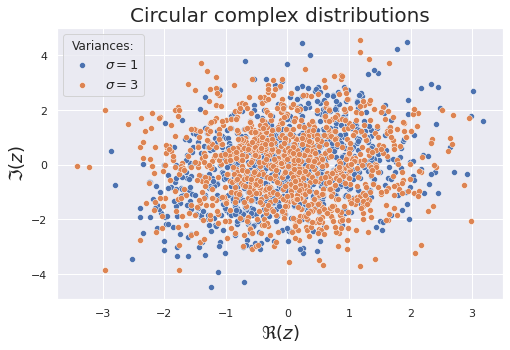

In [15]:
sample1 = generate_cmplx_distribution(cov_mat=noncirc_covmat_1, shape=(1000,))
sample2 = generate_cmplx_distribution(cov_mat=noncirc_covmat_2, shape=(1000,))

fig, ax = plt.subplots(1,1,figsize=(8,5))
sns.scatterplot(x=sample1.real, y=sample1.imag, ax=ax, label=r'$\sigma = 1.$')
sns.scatterplot(x=sample2.real, y=sample2.imag, ax=ax, label=r'$\sigma = 3.$')

ax.set_title('Circular complex distributions', fontsize=20)
ax.set_xlabel(r'$\Re(z)$', fontsize=18)
ax.set_ylabel(r'$\Im(z)$', fontsize=18)
ax.legend(title='Variances:', fontsize=13);

In [18]:
full_ds = torch.utils.data.ConcatDataset([noncirc1, noncirc2])
train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)

In [21]:
complex_hc_noncirc = Haiku_Classifier()
_ = complex_hc_noncirc.train(n_epochs = 50,
                             model = CVNN, 
                             optimizer = cmplx_adam(step_size=1e-2),
                             train_dataloader = train_dl,
                             test_dataloader = test_dl,
                             verbose = False)

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

In [19]:
real2ch_noncirc = Haiku_Classifier()
_ = real2ch_noncirc.train(n_epochs = 50,
                          model = NN2CH, 
                          optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                          train_dataloader = train_dl,
                          test_dataloader = test_dl,
                          verbose = False)

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

<AxesSubplot:xlabel='index', ylabel='train_acc'>

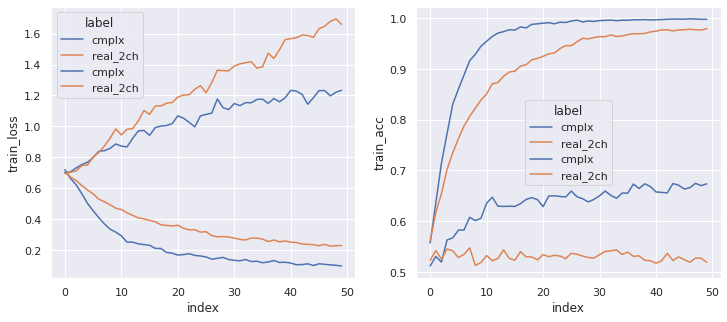

In [22]:
noncircular_train = pd.concat([pd.DataFrame(complex_hc_noncirc.training_history), pd.DataFrame(real2ch_noncirc.training_history)])
noncircular_train.reset_index(inplace=True)
noncircular_train['label'] = ['cmplx'] * 50 + ['real_2ch'] * 50

fig, ax = plt.subplots(1, 2, figsize=(12,5))

sns.lineplot(x='index', y='train_loss', hue='label', data=noncircular_train, ax=ax[0])
sns.lineplot(x='index', y='val_loss', hue='label', data=noncircular_train, ax=ax[0])

sns.lineplot(x='index', y='train_acc', hue='label', data=noncircular_train, ax=ax[1])
sns.lineplot(x='index', y='val_acc', hue='label', data=noncircular_train, ax=ax[1])

Let's try to understand what happens gradually changing the parameters.

In [11]:
def test_config(covmat_1, covmat_2):
    
    sigmaxy_1 = covmat_1[0,1]
    sigmaxy_2 = covmat_2[0,1]
    
    # Generate datasets
    dist1 = NpyDataset(generate_cmplx_distribution(cov_mat=covmat_1, shape=(5000,128)), label=0)
    dist1_rhoz, dist1_rho = get_circularity_coeff(dist1)
    print('Circularity coefficient first distribution: {:.4f}'.format(dist1_rhoz))
    print('Correlation coefficient first distribution {:.4f}'.format(dist1_rho))

    dist2 = NpyDataset(generate_cmplx_distribution(cov_mat=covmat_2, shape=(5000,128)), label=1)
    dist2_rhoz, dist2_rho = get_circularity_coeff(dist2)
    print('Circularity coefficient second distribution: {:.4f}'.format(dist2_rhoz))
    print('Correlation coefficient second distribution: {:.4f}'.format(dist2_rho))
    
    full_ds = torch.utils.data.ConcatDataset([dist1, dist2])
    train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
    train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)
    
    # Train the complex model
    complex_hc = Haiku_Classifier()
    _ = complex_hc.train(n_epochs = 50,
                         model = CVNN, 
                         optimizer = cmplx_adam(step_size=1e-2),
                         train_dataloader = train_dl,
                         test_dataloader = test_dl,
                         verbose = False)

    # Train the real model
    real2ch = Haiku_Classifier()
    _ = real2ch.train(n_epochs = 50,
                      model = NN2CH, 
                      optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                      train_dataloader = train_dl,
                      test_dataloader = test_dl,
                      verbose = False)
    
    train_results = pd.concat([pd.DataFrame(complex_hc.training_history), pd.DataFrame(real2ch.training_history)])
    train_results.reset_index(inplace=True)
    train_results['label'] = ['cmplx'] * 50 + ['real_2ch'] * 50

    fig, ax = plt.subplots(1, 2, figsize=(12,5))

    sns.lineplot(x='index', y='train_loss', hue='label', data=train_results, ax=ax[0])
    sns.lineplot(x='index', y='val_loss', hue='label', data=train_results, ax=ax[0])

    sns.lineplot(x='index', y='train_acc', hue='label', data=train_results, ax=ax[1])
    sns.lineplot(x='index', y='val_acc', hue='label', data=train_results, ax=ax[1])
    
    fig.savefig(f'dummy/test_{sigmaxy_1:.3f}_{sigmaxy_2:.3f}.png')
    plt.close()

In [13]:
covmat_1 = np.array([[1., .5],[.5, 2.]])
covmat_2 = np.array([[2., .5],[.5, 3.]])

def std_covmat(sxy):
    return np.array([[1., sxy], [sxy, 1.]])

for cov in np.linspace(-1., 1., 10):
    test_config(std_covmat(0.), std_covmat(cov))

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: 0.0008-0.0013j
Correlation coefficient second distribution -0.0013


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: 0.0000-1.0000j
Correlation coefficient: -1.0000


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: -0.0012+0.0002j
Correlation coefficient second distribution 0.0002


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.0002-0.7772j
Correlation coefficient: -0.7772


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: 0.0007-0.0020j
Correlation coefficient second distribution -0.0020


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.0001-0.5554j
Correlation coefficient: -0.5554


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: 0.0016-0.0007j
Correlation coefficient second distribution -0.0007


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: 0.0006-0.3348j
Correlation coefficient: -0.3348


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: 0.0016-0.0017j
Correlation coefficient second distribution -0.0017


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: 0.0014-0.1095j
Correlation coefficient: -0.1095


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: -0.0008+0.0010j
Correlation coefficient second distribution 0.0010


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.0007+0.1099j
Correlation coefficient: 0.1099


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: -0.0011+0.0010j
Correlation coefficient second distribution 0.0010


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: 0.0004+0.3306j
Correlation coefficient: 0.3306


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: -0.0009-0.0001j
Correlation coefficient second distribution -0.0001


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: 0.0005+0.5554j
Correlation coefficient: 0.5554


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: 0.0009-0.0005j
Correlation coefficient second distribution -0.0005


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: 0.0004+0.7775j
Correlation coefficient: 0.7775


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient first distribution: -0.0023+0.0002j
Correlation coefficient second distribution 0.0002


  0%|          | 0/5000 [00:00<?, ?it/s]

Circularity coefficient: -0.0000+1.0000j
Correlation coefficient: 1.0000


Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Training for several epochs:   0%|          | 0/50 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

Looping over the minibatches:   0%|          | 0/25 [00:00<?, ?it/s]

Computing the validation metrics:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
import cplot

In [ ]:
def test(z):
    return (1./ np.pi)*np.exp(-np.abs(z))

In [ ]:
plt.figure(figsize=(12,10))
cplot.plot(test, (-1.,1.,100), (-1.,1.,100))

In [ ]:
def complex_standard_multivariate_normal_pdf(z, n=1):
    
    z = np.array(z).reshape(1, -1)

    location = np.zeros(n, dtype=complex)
    covariance_matrix = np.eye(n, dtype=complex)
    relation_matrix = np.zeros(n, dtype=complex).reshape(n,n)
    
    R = np.conjugate(relation_matrix).T * np.linalg.inv(covariance_matrix)
    P = np.conjugate(covariance_matrix) - R*relation_matrix
    scale = 1. / (np.pi**n * np.sqrt(np.linalg.det(covariance_matrix) * np.linalg.det(P)))
    
    exp1 = np.hstack([(np.conjugate(z) - np.conjugate(location)).T, (z - location).T])

    row1 = np.hstack([covariance_matrix, relation_matrix])
    row2 = np.hstack([np.conjugate(relation_matrix), np.conjugate(covariance_matrix)])
    exp2 = np.linalg.inv(np.vstack([row1, row2]))
    
    exp3 = np.vstack([(z-location), (np.conjugate(z) - np.conjugate(location))])
        
    return scale * np.exp(-0.5 * exp1 @ exp2 @ exp3)

In [ ]:
cplot.plot(complex_standard_multivariate_normal_pdf, (-1.,1.,10), (-1.,1.,10))

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_folder, n_classes):

        self.X = []
        self.Y = []
        self.X_v = []
        self.metadata = []
        self.exps = []
        
        with open(data_folder + '.pkl', 'rb') as f:
            tmp = pickle.load(f)
            for a in tmp:
                self.X.append(tmp[a][0])
                self.X_v.append(tmp[a][1])
                self.Y.append(int(a.split('_c')[0]))
                self.metadata.append(tmp[a][2])
                self.exps.append(a.split('_')[1])

        self.X = np.stack(self.X)
        if len(self.X_v[0]) > 0:
            self.X_v = np.stack(self.X_v)
            self.dim_v = self.X_v.shape[1]
        else:
            ##1Hz data are not mandatory
            self.X_v = np.zeros(self.X.shape[0])
            self.dim_v = 0

        self.Y = np.array(self.Y)
        self.n_classes = n_classes

        self.nrow = self.X.shape[2]
        self.ncol = self.X.shape[3]
        self.n_channels = self.X.shape[1]
        print(f'    loaded {self.X.shape[0]} samples')

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idxs):
        x = self.X[idxs]
        y = self.Y[idxs]
        one_hot_y = np.eye(self.n_classes)[y]
        return [x, one_hot_y]

In [ ]:
data_dir = '/home/mattia/Desktop/PhysicsofData/Internship/data/input/'

In [ ]:
source_train = MyDataset(data_dir + 'source_train', n_classes=2)
source_test  = MyDataset(data_dir + 'source_test',  n_classes=2)
target_train = MyDataset(data_dir + 'target_train', n_classes=2)
target_test  = MyDataset(data_dir + 'target_test',  n_classes=2)

In [ ]:
print('Source train:')
source_train_rhoZ, source_train_rho = circularity_coeff(source_train)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(source_train_rhoZ, source_train_rho))

print('Source test:')
source_test_rhoZ, source_test_rho = circularity_coeff(source_test)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(source_test_rhoZ, source_test_rho))

print('Target train:')
target_train_rhoZ, target_train_rho = circularity_coeff(target_train)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(target_train_rhoZ, target_train_rho))

print('Target test:')
target_test_rhoZ, target_test_rho = circularity_coeff(target_test)
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(target_test_rhoZ, target_test_rho))

In [ ]:
hc_2ch = Haiku_Classifier(rng_seed=42, with_state=True)
history2 = complex_hc.train(n_epochs = 50, 
                     model = NN2CH, 
                     optimizer = jax.experimental.optimizers.adam(step_size=1e-2),
                     train_dataloader = train_dl,
                     test_dataloader = test_dl,
                     verbose = False)

small_training_summary(history2)

In [ ]:
class NN2CH(hk.Module):

    def __init__(self):

        super().__init__()
        self.real_fc1 = hk.Linear(64)
        self.real_fc2 = hk.Linear(16)
        
        self.imag_fc1 = hk.Linear(64)
        self.imag_fc2 = hk.Linear(16)
        
        self.out = hk.Linear(2)
        
        self.batchnorm_1D = hk.BatchNorm(create_scale=True, create_offset=True, decay_rate=0.9, data_format='NC')
        self.dropout = Dropout(0.2)
        self.act = jax.nn.relu

    def __call__(self, z, is_training):
        
        x = z.real
        y = z.imag

        x = self.act(self.real_fc1(x))
        x = self.dropout(x, is_training)
        x = self.batchnorm_1D(x, is_training)
        x = self.act(self.real_fc2(x))
        
        y = self.act(self.imag_fc1(y))
        y = self.dropout(y, is_training)
        y = self.batchnorm_1D(y, is_training)
        y = self.act(self.imag_fc2(y))
        
        xy = jnp.concatenate([x,y], axis=-1)
        out = self.out(xy)

        return out

In [ ]:
complex_hc = Haiku_Classifier(rng_seed=42, with_state=True)
history = complex_hc.train(n_epochs = 50, 
                     model = CVNN, 
                     optimizer = cmplx_adam(step_size=1e-2),
                     train_dataloader = train_dl,
                     test_dataloader = test_dl,
                     verbose = False)

small_training_summary(history)

In [ ]:
class CVNN(hk.Module):

    def __init__(self):

        super().__init__()
        self.fc1 = Cmplx_Linear(64)
        self.fc2 = Cmplx_Linear(16)
        self.fc3 = Cmplx_Linear(2)

        self.dropout = Dropout(0.2)
        self.act = cardioid

    def __call__(self, z, is_training):
        
        z = self.act(self.fc1(z))
        z = self.dropout(z, is_training)
        z = self.act(self.fc2(z))
        z = self.fc3(z)
        
        return z

In [ ]:
full_ds = torch.utils.data.ConcatDataset([NpyDataset(class0_data, label=0), NpyDataset(class1_data, label=1)])
train_ds, test_ds = torch.utils.data.random_split(full_ds, [8000, 2000])
train_dl = DataLoader(train_ds, batch_size=320, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=320, shuffle=False)

In [ ]:
class NpyDataset(Dataset):
    
    def __init__(self, data, label):
        
        self.x = data
        self.y = np.full(len(data), label)
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.x[idx].flatten())
        one_hot_y = torch.tensor(np.eye(2)[self.y[idx]])
        
        return (x, one_hot_y)

In [ ]:
import torch
import haiku as hk
import jax
import jax.numpy as jnp
from complex_nn.Classifier_wrapper import Haiku_Classifier
from complex_nn.Cmplx_Optimizers import cmplx_adam
from complex_nn.Cmplx_Layers import *
from complex_nn.Cmplx_Activations import *
from complex_nn.utils import *

In [ ]:
from complex_nn import Classifier_wrapper
reload(Classifier_wrapper)
from complex_nn.Classifier_wrapper import Haiku_Classifier

In [ ]:
from importlib import reload

In [ ]:
class0_data = generate_cmplx_distribution(cov_mat=np.array([[1.0, 2.],[2., 1.0]]), shape=(5000, 128))
class1_data = generate_cmplx_distribution(cov_mat=np.array([[1.0, -2.],[-2., 1.0]]), shape=(5000, 128))

plt.scatter(class0_data[0].real, class0_data[0].imag, c='red', marker='s', label='Class 0')
plt.scatter(class1_data[0].real, class1_data[0].imag, c='green', marker='o', label='Class 1')
plt.legend()

class0_rhoZ, class0_rho = circularity_coeff(np.expand_dims(class0_data, 1))
print('Class 0:')
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(class0_rhoZ, class0_rho))

class1_rhoZ, class1_rho = circularity_coeff(np.expand_dims(class1_data, 1))
print('Class 1:')
print('\tCircularity quotient: {:.5f},\t Correlation coefficient:{:.5f}'.format(class1_rhoZ, class1_rho))

In [ ]:
def generate_cmplx_distribution(cov_mat, shape):
    return np.random.multivariate_normal(np.zeros(2), cov_mat, size=shape).view(np.complex128)